Author: Paulina Pojda

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [2]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf]) 
    )

In [3]:
def solve_upwind(*, nt: int, C: float, psi: np.ndarray):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x, **kwargs):
    for label, data in kwargs.items():
        pyplot.step(x, data, label=label, where='mid', linewidth=2)
    pyplot.legend()
    pyplot.grid()
    show_plot()

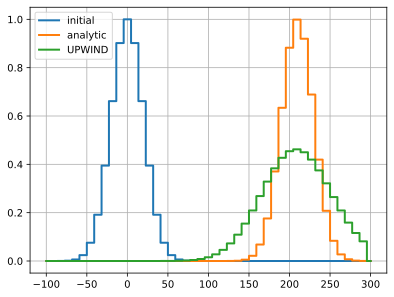

In [4]:
u = 3
t_max = 70

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - u * t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
)

In [5]:
def calculate_corrective_C(psi: np.ndarray, C: float, i: int):
    return (np.abs(C[i-hlf])-C[i-hlf]**2)*((psi[i]-psi[i-one])/(psi[i]+psi[i-one]))

In [6]:
def solve_mpdata(*, nt: int, C: float, psi: np.ndarray, n_iterations: int):
    for _ in range(nt):
        C_old = C
        upwind(psi, slice(1, len(C)), C)
        for i in range(n_iterations):
            C_cor = calculate_corrective_C(psi, C_old, slice(1, len(psi)))
            upwind(psi, slice(1, len(C_old)), C_cor)
            C_old = C_cor

    return psi

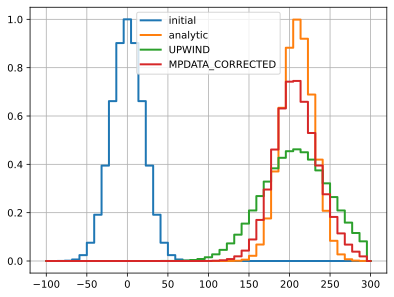

In [7]:
plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA_CORRECTED=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n_iterations = 1),
)

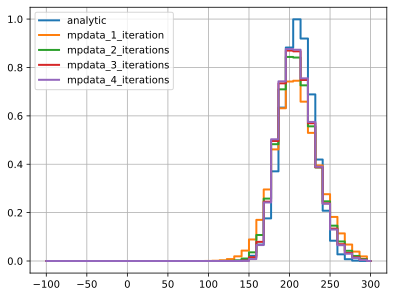

In [8]:
plot(
    x=x, 
    analytic=psi_0(x-u*t_max),
    mpdata_1_iteration=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n_iterations = 1),
    mpdata_2_iterations=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n_iterations = 2),
    mpdata_3_iterations=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n_iterations = 3),
    mpdata_4_iterations=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n_iterations = 4),
)

The plot compares the analytic solution of advection with MPDATA results using 1 to 4 corrective iterations.

With 1 iteration, MPDATA shows visible numerical diffusion. The peak is flattened and the shape is wider.
As the number of iterations increases, the numerical solution becomes sharper and more closely follows the analytic curve.
3 and 4 iterations yield very similar results, indicating that further corrections offer minimal improvement.
Conclusion: More iterations improve accuracy, but beyond 3, the benefit becomes marginal.